In [9]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import cv2
import numpy as np
from data_utils import JeongganboReader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from exp_utils import make_jng_gen_and_list, read_jngb, template_matching, COLOR_DICT

np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# Load Daegeum Yeo-Min-Rock Jeonggan-bo
* ymr: yeo min rock

In [11]:
reader = JeongganboReader()

ymr_infos = {
  "name": 'daegeum',
  "start": 17, # page 17 ~ 36
  "num_page": 20
}

ymr = read_jngb(reader, ymr_infos)
jng_gen, jng_list = make_jng_gen_and_list(reader, ymr)

Processing pngs/daegeum_pg-017.png
No jeonggan detected at pngs/daegeum_pg-017.png
Processing pngs/daegeum_pg-018.png
No jeonggan detected at pngs/daegeum_pg-018.png
Processing pngs/daegeum_pg-019.png
No jeonggan detected at pngs/daegeum_pg-019.png
Processing pngs/daegeum_pg-020.png
Processing pngs/daegeum_pg-021.png
Processing pngs/daegeum_pg-022.png
Processing pngs/daegeum_pg-023.png
Processing pngs/daegeum_pg-024.png
Processing pngs/daegeum_pg-025.png
Processing pngs/daegeum_pg-026.png
Processing pngs/daegeum_pg-027.png
Processing pngs/daegeum_pg-028.png
Processing pngs/daegeum_pg-029.png
Processing pngs/daegeum_pg-030.png
Processing pngs/daegeum_pg-031.png
Processing pngs/daegeum_pg-032.png
Processing pngs/daegeum_pg-033.png
Processing pngs/daegeum_pg-034.png
Processing pngs/daegeum_pg-035.png
Processing pngs/daegeum_pg-036.png


# Load pattern image paths

In [12]:
import glob

pattern_path_base = 'test/daegeum/'
pattern_path_sub = ['notations/', 'pitches/']
pattern_ext = '.png'

pattern_paths = { 
  subpath[:-1]: {
    path.replace(f'{pattern_path_base}{subpath}', '').replace(pattern_ext, ''): path \
    for path in glob.glob(f'{pattern_path_base}{subpath}*{pattern_ext}')
  } for subpath in pattern_path_sub 
}

print([ name for name in pattern_paths['notations'].keys() ])
print([ name for name in pattern_paths['pitches'].keys() ])

['pause', 'no_ni_ro', 'neu_na', 'ri', 'ni_na', 'ne_ro_ne', 'yo', 'neu_ne_neu', 'neu_na_reu_na_ni', 'dn_flow', 'neu_na_ni_na', 'no', 'dn_yo', 'niro', 'none', 'ro', 'ni_ro_na', 'nire', 'neo_nye', 'flow', 'push', 'ne_ro_na', 'dn_push', 'no_ri_no', 'ni', 'nina', 'conti', 'neu_ni', 'na_nue_na', 'accent', 'na_ni_na', 'no_ra', 'ni_neu_ra_ni', 'ni_re_na']
['nam_d', 'hwang_u', 'nam_u', 'joong', 'tae_u', 'lim_d', 'tae', 'mu', 'joong_u', 'mu_d', 'nam', 'mu_u', 'lim_u', 'lim', 'hwang_uu', 'hwang']


In [13]:
target_jng_list = jng_list

## preview Jeonggan

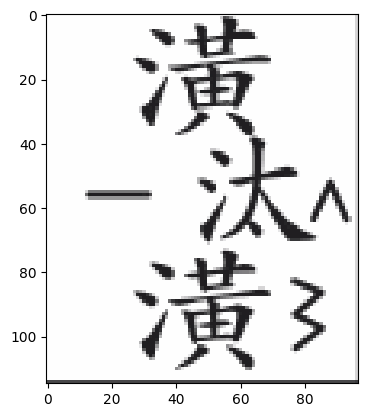

In [14]:
img_preview, _ = target_jng_list[289]
plt.imshow(img_preview)

# tempalte matching bounding box merging

## raw template matching bounding boxes
* 0: lim, hwang_u
* 4: nam, lim
* 43: joong, tae
* 161: nam, lim, nam
* 286: lim, nam, lim
* 289: hwang, tae, hwang

12


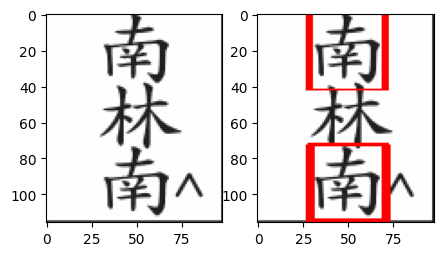

In [15]:
THRESHOLD = 0.42
MATCH_MODE = cv2.TM_CCOEFF_NORMED
PTRN_SIZE = 42

img, _ = target_jng_list[161]
ptrn = cv2.imread(pattern_paths['pitches']['nam'])

yCords, xCords, _ = template_matching(img, ptrn, PTRN_SIZE, THRESHOLD, MATCH_MODE)

img_cp = img.copy()

for x, y in zip(xCords, yCords):
  cv2.rectangle(img_cp, (x, y), (x + PTRN_SIZE, y + PTRN_SIZE), (255, 0, 0), 1)

print(len(list(zip(xCords, yCords))))

plt.figure(figsize=(5, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(img_cp)

## merged bounding box

[merging algorithm reference](https://stackoverflow.com/questions/66490374/how-to-merge-nearby-bounding-boxes-opencv)

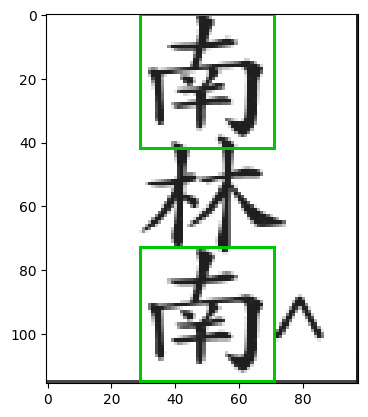

In [16]:
def is_overlap(source, target):
  # tl: top-left / br: bottom-right
  s_tl_x, s_tl_y, s_br_x, s_br_y = source 
  t_tl_x, t_tl_y, t_br_x, t_br_y = target

  # source top-left x >= target bottom-right x OR target top-left x >= source bottom-right x
  if ( s_tl_x >= t_br_x or t_tl_x >= s_br_x ):
    return False
  # source top-left y >= target bottom-right y OR target top-left y >= source bottom-right y
  if ( s_tl_y >= t_br_y or t_tl_y >= s_br_y ):
    return False
  
  return True

def get_overlaps(boxes, target_box, target_idx):
  overlaps = []
  for idx, box in enumerate(boxes):
    if idx != target_idx and is_overlap(target_box, box):
      overlaps.append( (box, idx) )
  return overlaps

def get_merged(boxes):
  centers_x = []
  centers_y = []
  
  for box in boxes:
    tl_x, tl_y, br_x, br_y = box
    center_x = tl_x + (br_x - tl_x)//2
    center_y = tl_y + (br_y - tl_y)//2
    
    centers_x.append(center_x)
    centers_y.append(center_y)
  
  w_half = (boxes[0][2] - boxes[0][0])//2
  h_half = (boxes[0][3] - boxes[0][1])//2
  
  center_x = round(np.mean(centers_x))
  center_y = round(np.mean(centers_y))
  
  return center_x - w_half, center_y - h_half, center_x + w_half, center_y + h_half

def merge_bboxs(bboxs, margin=0):
  bboxs_merged = []
  index = 0

  while True:
    if index > len(bboxs) - 1:
      break
    
    curr = bboxs[index]
    tl_x, tl_y, br_x, br_y = curr # tl: top-left / br: bottom-right

    # overlapping box indexs
    overlaps = get_overlaps(bboxs, (tl_x, tl_y, br_x, br_y), index)
    
    if len(overlaps) > 0:
      # remove overlaps
      overlaps_box = [ tup[0] for tup in overlaps]
      overlaps_box.append(curr)
      
      bboxs_merged.append( get_merged(overlaps_box) )
      
      overlaps_idx = [ tup[1] for tup in overlaps ]
      overlaps_idx.sort(reverse=True)
      for overlap_idx in overlaps_idx:
        assert overlap_idx < len(bboxs), f'index out of range: {overlap_idx} / {len(bboxs) - 1}' 
        del bboxs[overlap_idx]
        
    else:
      bboxs_merged.append(curr)
  
    index += 1
    
  return bboxs_merged


def process_bboxs(xCords, yCords):
  bboxs = zip(xCords, yCords)
  bboxs = [(bbox[0], bbox[1], bbox[0] + PTRN_SIZE, bbox[1] + PTRN_SIZE) for bbox in bboxs]
  bboxs = sorted(bboxs, key=lambda b: b[1])

  return merge_bboxs(bboxs)

bboxs_merged = process_bboxs(xCords, yCords)
  
img_copy = img.copy()

for box in bboxs_merged:
  tl_x, tl_y, br_x, br_y = box
  cv2.rectangle(img_copy, (tl_x, tl_y), (br_x, br_y), (0, 200, 0), 1)
  
plt.imshow(img_copy)


## bounding box merging batch test

### bounding box swatch

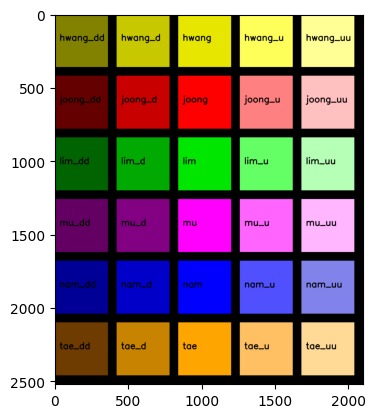

In [17]:
size = 360
row = 6
col = 5
margin = size // 6
font_size = 2
font_weight = 5

empty = np.zeros( ( (size + margin) * row, (size + margin) * col, 3 ) )

for idx, (key, value) in enumerate(COLOR_DICT.items()):
  start_x = (idx%5) * (size + margin)
  start_y = (idx//5) * (size + margin)
  cv2.rectangle(empty, (start_x, start_y), (start_x + size, start_y + size), value, -30)
  cv2.putText(empty, key, (start_x + margin//2, start_y + (size//2)), cv2.FONT_ITALIC, font_size, (0, 0, 0), font_weight)
  
plt.imshow(empty.astype('uint8'))


### multiple pitch names in single Jeonggan
* 161: nam, lim, nam

total bbox 5


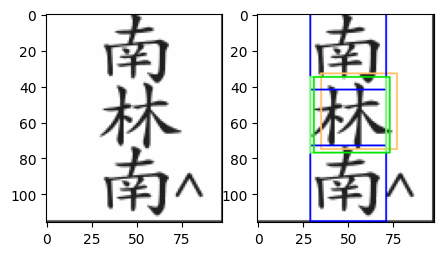

In [12]:
THRESHOLD = 0.42
MATCH_MODE = cv2.TM_CCOEFF_NORMED
PTRN_SIZE = 42
JNG_INDICES = [0, 4, 43, 161, 286, 289]

jng_img, _ = target_jng_list[161]

jng_bbox_dict = {}
bbox_total = 0

for ptrn_key, ptrn_path in pattern_paths['pitches'].items():
  ptrn = cv2.imread(ptrn_path)
  yCords, xCords, result = template_matching(jng_img, ptrn, PTRN_SIZE, THRESHOLD, MATCH_MODE)
  
  bboxs_merged = process_bboxs(xCords, yCords)
  
  bbox_total += len(bboxs_merged) # for debugging
  
  if(len(bboxs_merged) > 0):
    jng_bbox_dict[ptrn_key] = bboxs_merged

print('total bbox', bbox_total)

jng_img_cp = jng_img.copy()

for pitch_name, bboxs in jng_bbox_dict.items():
  color = COLOR_DICT[pitch_name]
  
  for box in bboxs:
    tl_x, tl_y, br_x, br_y = box
    cv2.rectangle(jng_img_cp, (tl_x, tl_y), (br_x, br_y), color, 1)

plt.figure(figsize=(5, 5))

plt.subplot(1, 2, 1)
plt.imshow(jng_img)

plt.subplot(1, 2, 2)
plt.imshow(jng_img_cp)

### multiple pitch names in multiple Jeonggans 
**without similar pitch name checking** 

* 0: lim, hwang_u
* 4: nam, lim
* 43: joong, tae
* 161: nam, lim, nam
* 286: lim, nam, lim
* 289: hwang, tae, hwang

total bbox count:  41
0 th jng has  ['hwang_uu', 'hwang_u', 'hwang', 'nam_u']


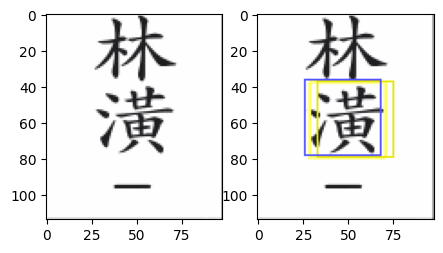

4 th jng has  ['joong', 'lim_u', 'lim_d', 'lim', 'nam', 'tae_u']


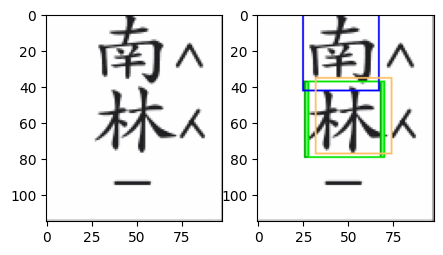

43 th jng has  ['joong', 'lim', 'mu_d', 'nam_u', 'nam_d', 'tae_u', 'tae']


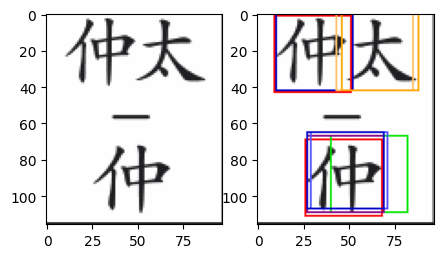

161 th jng has  ['lim_u', 'lim', 'nam', 'tae_u']


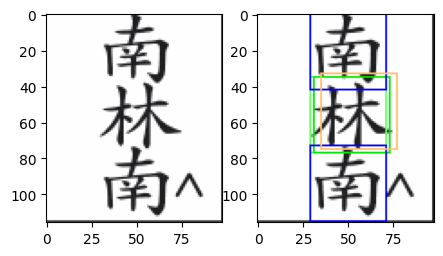

286 th jng has  ['joong', 'lim_u', 'lim_d', 'lim', 'nam_u', 'nam_d', 'nam', 'tae_u', 'tae']


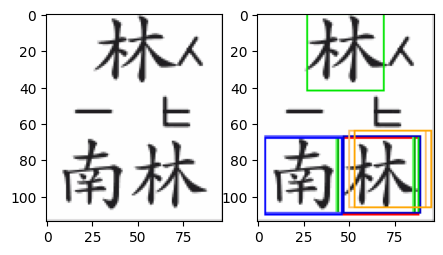

289 th jng has  ['hwang_uu', 'hwang_u', 'hwang', 'mu_u', 'tae_u', 'tae']


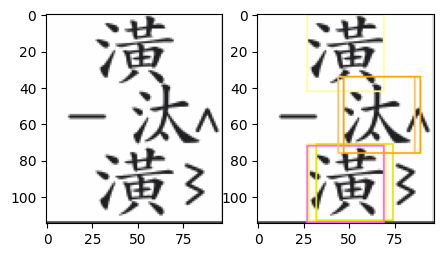

In [41]:
THRESHOLD = 0.42
MATCH_MODE = cv2.TM_CCOEFF_NORMED
PTRN_SIZE = 42
PTRN_TEST_ORDER = ['hwang_uu', 'hwang_u', 'hwang', 'joong_u', 'joong', 'lim_u', 'lim_d', 'lim', 'mu_d', 'mu_u', 'mu', 'nam_u', 'nam_d', 'nam', 'tae_u', 'tae']

PNAME_SURFIXS = ['uu, u, d, dd']

JNG_INDICES = [0, 4, 43, 161, 286, 289]

ptrn_dict = { name: cv2.imread(pattern_paths['pitches'][name]) for name in PTRN_TEST_ORDER }

jng_img_bbox_dict_list = []
bbox_total = 0

for jng_idx in JNG_INDICES:
  jng_img, _ = target_jng_list[jng_idx]
  
  jng_bbox_dict = {}
  
  for ptrn_key, ptrn in ptrn_dict.items():
    yCords, xCords, img_w_bbox = template_matching(jng_img, ptrn, PTRN_SIZE, THRESHOLD, MATCH_MODE)
    
    bboxs_merged = process_bboxs(xCords, yCords)
    
    bbox_total += len(bboxs_merged) # for debugging
    
    if len(bboxs_merged) > 0:
      jng_bbox_dict[ptrn_key] = bboxs_merged
  
  jng_img_bbox_dict_list.append( (jng_img, jng_img.copy(), jng_bbox_dict) )
  
print('total bbox count: ', bbox_total)

for idx, obj in enumerate(jng_img_bbox_dict_list):
  jng_img, jng_img_cp, jng_bbox_dict = obj
  
  for pitch_name, bboxs in jng_bbox_dict.items():
    color = COLOR_DICT[pitch_name]
  
    for box in bboxs:
      tl_x, tl_y, br_x, br_y = box
      cv2.rectangle(jng_img_cp, (tl_x, tl_y), (br_x, br_y), color, 1)
  
  print(JNG_INDICES[idx], "th jng has ", list(jng_bbox_dict.keys()))
  
  plt.figure(figsize=(5, 5))
  
  plt.subplot(1, 2, 1)
  plt.imshow(jng_img)

  plt.subplot(1, 2, 2)
  plt.imshow(jng_img_cp)
  
  plt.show()
